In [ ]:
import concurrent.futures
from tqdm import tqdm

def process_iteration(qerr_i, latest_in, latest_tc, coll, pred_cumulate):
    # Your existing loop body here

# Your existing function definition here

def decodePreds_parallel(inputs, preds, truecards, collist):
    global global_table 
    global global_cols_alldomain 
    
    latest_inputs = inputs[:, -1, :]
    latest_truecards = truecards[:, -1]
    
    total_iterations = len(latest_inputs)
    q_error_list = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Use ThreadPoolExecutor for CPU-bound tasks; for IO-bound tasks, consider ProcessPoolExecutor
        futures = {executor.submit(process_iteration, qerr_i, latest_in, latest_tc, coll, pred_cumulate):
                   (qerr_i, latest_in, latest_tc, coll, pred_cumulate) for qerr_i, (latest_in, latest_tc, coll, pred_cumulate)
                   in enumerate(zip(latest_inputs, latest_truecards, collist, preds))}
        
        for future in tqdm(concurrent.futures.as_completed(futures), total=total_iterations, desc="Processing"):
            try:
                q_error_list.append(future.result())
            except Exception as e:
                print(f"An error occurred: {e}")
                
    return q_error_list


In [ ]:
def decodePreds(inputs, preds, truecards, collist):
    global global_table 
    global global_cols_alldomain 
    
    latest_inputs = inputs[:, -1, :].to('cpu') # 获取最新的查询。latest_inputs获取最外层32个[50, 11]维数组中，每个50个11维数组的最后一个11维数组。latest_inputs[32, 11]
    latest_truecards = truecards[:, -1].to('cpu') # 获取最新的truecards
    preds = preds.to('cpu') 
    
    # limit_q_error_num = 3
    q_error_list = []
    total_iterations = len(latest_inputs) # 总计算数量，用于tqdm进度展示
    for q_error_i, (latest_in, latest_tc, coll, pred_cumulate) in tqdm(enumerate(zip(latest_inputs, latest_truecards, collist, preds)), total=total_iterations, desc="Processing"):
        
        # TODO 为了加速计算，每一个iteration只算limit_q_error_num个query的q-error
        # if q_error_i >= limit_q_error_num:
        #     break
        # TODO 为了加速计算所以continue
        if "capital_loss" in coll:
            continue
        
        # L.info(f"{coll}")
        coll_list = coll.split("/") # coll 'age/capital_loss'
        col_df = global_cols_alldomain[coll] # col_df是coll(age/capital_loss')对应的联合域信息
        
        domain_list = [] # 存储所有满足query谓词的联合域的域位置。即10000维数组中满足query的index。
        for _, row in col_df.iterrows():
            row_in_domain = True
            for coll_list_index in range(len(coll_list)):
                if(row[coll_list[coll_list_index]] < latest_in[(coll_list_index + 1) *2 - 1] or row[coll_list[coll_list_index]] > latest_in[(coll_list_index + 1)*2]):
                    row_in_domain = False
                if row_in_domain == False:
                    break
            if row_in_domain == True:
                domain_list.append(row["index_alldomain"])
            
        pred = [pred_cumulate[i] - pred_cumulate[i-1] if i > 0 else pred_cumulate[i] for i in range(len(pred_cumulate))] # pred_cumulate是累计概率。pred是当前分位点的概率。
        domain_list_sum = np.sum([pred[int(i)] for i in domain_list]) # domain_list上所有分位点概率和
        estimate_card = domain_list_sum * global_table.row_num # 预估的基数
        q_error = Q_error(estimate_card, latest_tc) # 计算q_error
        # L.info(type(q_error))
        # L.info(f"estimate {estimate_card}; true {latest_tc}; q-error {q_error}")
        q_error_list.append(q_error)           
    return q_error_list

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 其他部分代码...

# 创建子图
fig, ax1 = plt.subplots()

# 绘制训练损失和验证损失曲线
ax1.plot(train_avgloss_epoch_list, label='Training Loss', color='blue')
ax1.plot(valid_avgloss_epoch_list, label='Validation Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# 创建第二个y轴，用于绘制箱型图
ax2 = ax1.twinx()

# 生成随机的示例数据，因为我不知道你的 valid_qerror_list 数据结构
# 请替换这里的随机数据为你的实际数据
valid_qerror_list = [np.random.normal(0, 1, size=50) for _ in range(len(valid_avgloss_epoch_list))]

# 绘制箱型图
ax2.boxplot(valid_qerror_list, positions=np.arange(1, len(valid_avgloss_epoch_list) * 10 + 1, 10), vert=False)
ax2.set_ylabel('Validation QError', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_yticklabels([])  # 隐藏y轴标签
ax2.legend(loc='upper right')

# 设置标题
plt.title('Training Loss, Validation Loss, and Validation QError Over Epochs')

# 保存图像
plt.savefig(train_fig_file)

# 显示图形
plt.show()


In [7]:
import numpy as np
chsdoi = [32, 2323]
lis = [i * 10 for i in range(1, len(chsdoi))]
lis

[10]

In [8]:
lis = [1] + lis
lis

[1, 10]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

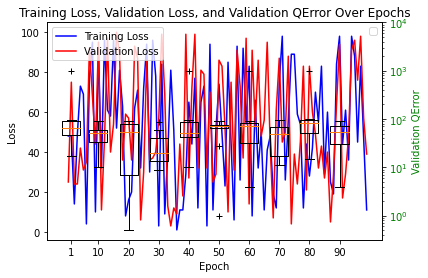

In [3]:
import matplotlib.pyplot as plt
import random

train_avgloss_epoch_list = [random.randint(1, 100) for _ in range(100)]
valid_avgloss_epoch_list = [random.randint(1, 100) for _ in range(100)]
valid_qerror_epoch_list = [[random.randint(1, 100) for _ in range(8)] +[1000], [random.randint(1, 100) for _ in range(10)],
                           [random.randint(1, 100) for _ in range(8)] +[0.5], [random.randint(1, 100) for _ in range(10)],
                           [random.randint(1, 100) for _ in range(8)] +[1000], [random.randint(1, 100) for _ in range(10)],
                           [random.randint(1, 100) for _ in range(8)] +[1000], [random.randint(1, 100) for _ in range(10)],
                           [random.randint(1, 100) for _ in range(8)] +[1000], [random.randint(1, 100) for _ in range(10)]]
fig, ax1 = plt.subplots()
ax1.plot(train_avgloss_epoch_list, label='Training Loss', color='blue')
ax1.plot(valid_avgloss_epoch_list, label='Validation Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left') # 在左轴上添加图例

ax2 = ax1.twinx() # 在同一个图表上创建一个新的y轴，与原始的y轴（ax1）共享x轴。
# ax2.plot(valid_avgqerror_epoch_list, label='Validation QError', color='green')
ax2.boxplot(valid_qerror_epoch_list, positions=[1]+[i * 10 for i in range(1, len(valid_qerror_epoch_list))], sym='+', vert=True, widths=6)
ax2.set_ylabel('Validation QError', color='green')
ax2.tick_params(axis='y', labelcolor='green')
# ax2.set_yticklabels([])  # 隐藏y轴标签
ax2.legend(loc='upper right')
ax2.set_ylim(10**-0.5, 10**2)  # 设置右轴的纵轴范围
ax2.set_yscale('log')

plt.title('Training Loss, Validation Loss, and Validation QError Over Epochs')
plt.show